# Remake Figure S5: Analyze Kinetics and Robustness to Noise

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20231019

This notebook is designed to reproduce figures from the paper using the archived data folder. Each section should be possible to run independently.

Note that this notebook is primarily intended for users who wish to replot the existing data in different ways; it does not include code for the analysis itself.

In [1]:
import importlib
import itertools
import math
import numpy as np
import os
import pandas as pd
import pathlib
import scipy.stats
import sys
import time

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import seaborn as sns


In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [ ]:
# Define directory of the archived data folder parresgold_2023_dimer_networks_data
load_dir = str(pathlib.Path('E:\\','parresgold_2023_dimer_networks','parresgold_2023_dimer_networks_data'))

In [66]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [5]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [6]:
# Suppress warnings from seaborn for trying to plot too many points in a swarm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [7]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


C:\Users\jacob\AppData\Local\Temp\ipykernel_3176\3780498324.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## Figure S5A: Equilibration Time

In [24]:
m_list = list(range(2,13))

param_sets_per_m = 20

default_time = 10000 # s
max_time = 10000000 

vol_per_cell = 1e-12 # L
unitless_conc_per_molecule = 0.001

k_on = 5e5 # M-1 s-1
k_on_unitless = k_on/6.0221e23/vol_per_cell # molecule-1 s-1

rng = np.random.default_rng()

Load data:

In [25]:
input_i_at_eq = 29 # We simulated equilibration from input_i = 0 to input_i = 29

param_sets_by_m = []
S_all_by_m = []
num_edges_to_test_by_m = []
k_offs_by_m_by_pset_by_species = []
time_to_equilibrium_by_m_by_pset_by_species = [] 

for m in m_list:
    m_i = m_list.index(m)
    specific_out_dir = str(pathlib.Path(load_dir,'equilibration_time',f'{m}M'))
    param_sets_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'param_sets.npy')),allow_pickle=True))
    S_all_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'S_all.npy')),allow_pickle=True))
    num_edges_to_test_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'num_edges_to_test.npy')),allow_pickle=True))
    k_offs_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'k_offs_by_pset_by_species.npy')),allow_pickle=True))
    time_to_equilibrium_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'time_to_equilibrium_by_pset_by_species.npy')),allow_pickle=True))

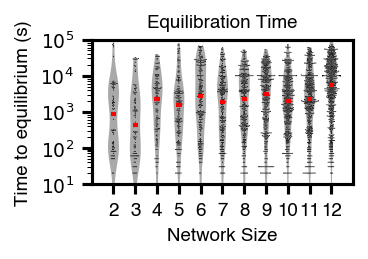

In [26]:
save = True

fig, ax = plt.subplots(figsize=(2.25,1.25))

max_time_obs = 10**math.ceil(np.log10(np.max(list(itertools.chain.from_iterable(itertools.chain.from_iterable(time_to_equilibrium_by_m_by_pset_by_species))))))

time_to_equilibrium_by_m = []

for m in m_list:
    m_i = m_list.index(m)
    time_to_equilibrium = np.array(list(itertools.chain.from_iterable(time_to_equilibrium_by_m_by_pset_by_species[m_i][param_set_i] for param_set_i in range(param_sets_per_m))))
    time_to_equilibrium = time_to_equilibrium[np.where(time_to_equilibrium>0)]
    time_to_equilibrium_by_m.append(np.log10(time_to_equilibrium))

parts = ax.violinplot(positions = m_list,\
           dataset = time_to_equilibrium_by_m,\
          #  labels = [str(m) for m in m_list],\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('darkgray')
    face.set_alpha(1)

parts['cmedians'].set_color('red')
parts['cmedians'].set_linewidth(2)

subsample = 1000
size = 0.5
for m,points in zip(m_list,time_to_equilibrium_by_m):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

parts['cmedians'].set_zorder(10)

log_min_y = 1
log_max_y = 5
ax.set_ylim([log_min_y,log_max_y])
ax.set_xlim([m_list[0]-1,m_list[-1]+1])
ax.set_yticks(range(log_min_y,log_max_y+1),labels=['$10^{{{}}}$'.format(x) for x in range(log_min_y,log_max_y+1)],fontname='Helvetica',minor=False)
ax.set_yticks(list(itertools.chain.from_iterable([[np.log10((10**x)*y) for y in np.arange(2,10)] \
            for x in range(log_min_y,log_max_y)])),minor=True)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks


ax.set_xticks(m_list)
_ = ax.set_ylabel('Time to equilibrium (s)')
_ = ax.set_xlabel('Network Size')
_ = ax.set_title('Equilibration Time')

if save:
    filename = f'FigS5A_time_to_eq_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## FIgure S5B: Separation of Timescales

In [8]:
periods_to_test = np.load(str(pathlib.Path(load_dir,'separation_of_timescales','periods_to_test.npy')), allow_pickle=True)
fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(load_dir,'separation_of_timescales','fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)

m_list = list(range(2,13))

chebyshev_threshold = 0.5

In [ ]:
fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(load_dir,'separation_of_timescales','fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)
stdev_fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(load_dir,'separation_of_timescales','stdev_fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)
min_fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(load_dir,'separation_of_timescales','min_fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)
max_fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(load_dir,'separation_of_timescales','max_fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)
Q1_fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(load_dir,'separation_of_timescales','Q1_fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)
Q3_fraction_acceptable_by_timescale_by_m = np.load(str(pathlib.Path(load_dir,'separation_of_timescales','Q3_fraction_acceptable_by_timescale_by_m.npy')), allow_pickle=True)
fraction_simulations_failed_by_timescale_by_m = np.load(str(pathlib.Path(load_dir,'separation_of_timescales','fraction_simulations_failed_by_timescale_by_m.npy')), allow_pickle=True)

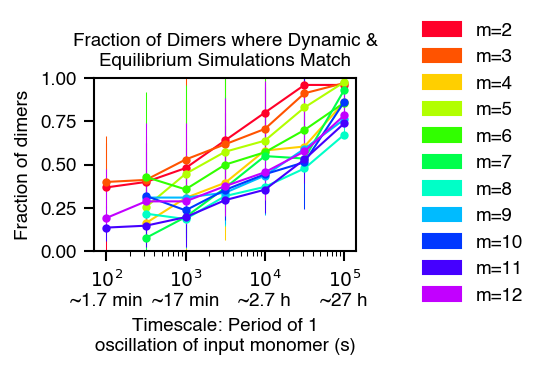

In [65]:
save = True
errorbars = True
max_fraction_simulations_failed = 0.2

fig, ax = plt.subplots(figsize=(2.25,1.5))

cmap = plt.get_cmap('gist_rainbow')

x_positions = np.log10(periods_to_test)

if errorbars:
    for m in m_list:
        m_i = m_list.index(m)
        successful_x_positions = [x for i,x in enumerate(x_positions) if fraction_simulations_failed_by_timescale_by_m[m_i][i]<=max_fraction_simulations_failed]
        successful_fractions_acceptable = [y for i,y in enumerate(fraction_acceptable_by_timescale_by_m[m_i]) if fraction_simulations_failed_by_timescale_by_m[m_i][i]<=max_fraction_simulations_failed]
        # Same upper and lower error bars
        # successful_errorbars = [y for i,y in enumerate(stdev_fraction_acceptable_by_timescale_by_m[m_i]) if fraction_simulations_failed_by_timescale_by_m[m_i][i]<=max_fraction_simulations_failed]
        
        # With different upper and lower error bars
        # In some cases, small negative values from the discretization of quantiles vs. means are set to 0
        successful_errorbars_lower = [np.max([fraction_acceptable_by_timescale_by_m[m_i][i]-y,0]) for i,y in enumerate(Q1_fraction_acceptable_by_timescale_by_m[m_i]) if fraction_simulations_failed_by_timescale_by_m[m_i][i]<=max_fraction_simulations_failed]
        successful_errorbars_upper = [np.max([y-fraction_acceptable_by_timescale_by_m[m_i][i],0]) for i,y in enumerate(Q3_fraction_acceptable_by_timescale_by_m[m_i]) if fraction_simulations_failed_by_timescale_by_m[m_i][i]<=max_fraction_simulations_failed]
        successful_errorbars = np.vstack((successful_errorbars_lower,successful_errorbars_upper))

        # Plot error bars
        _ = ax.errorbar(successful_x_positions,successful_fractions_acceptable,yerr=successful_errorbars,fmt='none',elinewidth=0.5,capsize=0,ecolor=cmap((m_i/(len(m_list)))))

        # Simply plot ranges as dotted lines
        # successful_lower_range = [y for i,y in enumerate(Q1_fraction_acceptable_by_timescale_by_m[m_i]) if fraction_simulations_failed_by_timescale_by_m[m_i][i]<=max_fraction_simulations_failed]
        # successful_upper_range = [y for i,y in enumerate(Q3_fraction_acceptable_by_timescale_by_m[m_i]) if fraction_simulations_failed_by_timescale_by_m[m_i][i]<=max_fraction_simulations_failed]
        # _ = ax.plot(successful_x_positions,successful_lower_range,marker='',linestyle='--',linewidth=0.5,color=cmap((m_i/(len(m_list)))))
        # _ = ax.plot(successful_x_positions,successful_upper_range,marker='',linestyle='--',linewidth=0.5,color=cmap((m_i/(len(m_list)))))

for m in m_list:
    m_i = m_list.index(m)
    successful_x_positions = [x for i,x in enumerate(x_positions) if fraction_simulations_failed_by_timescale_by_m[m_i][i]<=max_fraction_simulations_failed]
    successful_fractions_acceptable = [y for i,y in enumerate(fraction_acceptable_by_timescale_by_m[m_i]) if fraction_simulations_failed_by_timescale_by_m[m_i][i]<=max_fraction_simulations_failed]
    _ = ax.plot(successful_x_positions,successful_fractions_acceptable,marker='.',markersize=6,linestyle='-',linewidth=1,color=cmap((m_i/(len(m_list)))))

# Set x ticks
x_tick_approximations = [
    '~1.7 min',
    '~17 min',
    '~2.7 h',
    '~27 h'
]

xmin = math.floor(x_positions[0])
xmax = math.ceil(x_positions[-1])
log_xtick_locations_inclusive = np.arange(xmin,xmax+1)
log_xtick_locations = np.arange(xmin,xmax)
_ = ax.set_xticks(log_xtick_locations_inclusive)
label_every = 1
_ = ax.set_xticklabels(['$10^{{{}}}$\n{}'.format(x,x_tick_approximations[i]) if i%label_every==0 else '' for i,x in enumerate(log_xtick_locations_inclusive)])
_ = ax.set_xticks(list(itertools.chain.from_iterable([[np.log10((10**float(x))*y) for y in np.arange(2,10)] \
            for x in log_xtick_locations])),minor=True)

_ = ax.set_xlabel('Timescale: Period of 1\noscillation of input monomer (s)')

# Set ylim
_ = ax.set_ylim([0,1])

# _ = ax.set_ylabel(f'Fraction where worst-point difference\n<{chebyshev_threshold} log unit')
_ = ax.set_ylabel(f'Fraction of dimers')

# _ = ax.axhline(y=1, color='k', linestyle='--', linewidth=1)

# Set title
_ = ax.set_title('Fraction of Dimers where Dynamic &\nEquilibrium Simulations Match')

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

# Legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1.05, 0.5), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    errorbars_label = '_errorbars' if errorbars else ''
    filename = f'FigS5B_fraction_acceptable_by_period_by_m'+errorbars_label
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Figure S5C-S5D: Intrinsic Noise

In [17]:
m_list = list(range(2,13))

param_sets_per_m = 20

default_time = 10000 # s
max_time = 10000000 

vol_per_cell = 1e-12 # L
unitless_conc_per_molecule = 0.001

k_on = 5e5 # M-1 s-1
k_on_unitless = k_on/6.0221e23/vol_per_cell # molecule-1 s-1

rng = np.random.default_rng()

Load data:

In [18]:
param_sets_by_m = []
S_all_by_m = []
num_edges_to_test_by_m = []
k_offs_by_m_by_pset_by_species = []
input_i_by_m_by_pset = []
coeff_noise_by_m_by_pset_by_species = []
stdev_noise_by_m_by_pset_by_species = []   

for m in m_list:
    m_i = m_list.index(m)
    specific_out_dir = str(pathlib.Path(load_dir,'intrinsic_noise',f'{m}M'))
    param_sets_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'param_sets.npy')),allow_pickle=True))
    S_all_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'S_all.npy')),allow_pickle=True))
    num_edges_to_test_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'num_edges_to_test.npy')),allow_pickle=True))
    k_offs_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'k_offs_by_pset_by_species.npy')),allow_pickle=True))
    input_i_by_m_by_pset.append(np.load(str(pathlib.Path(specific_out_dir,f'input_i_by_pset.npy')),allow_pickle=True))
    coeff_noise_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'coeff_noise_by_pset_by_species.npy')),allow_pickle=True))
    stdev_noise_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'stdev_noise_by_pset_by_species.npy')),allow_pickle=True))

### Figure S5C

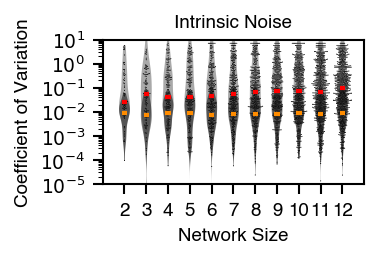

In [19]:
save = True

fig, ax = plt.subplots(figsize=(2.25,1.25))

abundance_threshold = 100

coeff_noise_by_m = []
coeff_noise_by_m_highabundance = []
for m in m_list:
    m_i = m_list.index(m)
    S_all = S_all_by_m[m_i]
    S_all[np.where(S_all<1e-3)] = 1e-3
    coeff_noise = []
    coeff_noise_highabundance = []
    for param_set_i in range(param_sets_per_m):
        coeff_noise_temp = coeff_noise_by_m_by_pset_by_species[m_i][param_set_i]
        coeff_noise+= list(coeff_noise_temp)
        abundances = S_all[input_i_by_m_by_pset[m_i][param_set_i],:,param_set_i]/unitless_conc_per_molecule
        coeff_noise_highabundance+= list(coeff_noise_temp[np.where(abundances>abundance_threshold)])
    coeff_noise = np.array(coeff_noise)
    coeff_noise = coeff_noise[np.where(coeff_noise>0)]
    coeff_noise_by_m.append(np.log10(coeff_noise))

    coeff_noise_highabundance = np.array(coeff_noise_highabundance)
    coeff_noise_highabundance = coeff_noise_highabundance[np.where(coeff_noise_highabundance>0)]
    coeff_noise_by_m_highabundance.append(np.log10(coeff_noise_highabundance))
    

parts = ax.violinplot(positions = m_list,\
           dataset = coeff_noise_by_m,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('darkgray')
    face.set_alpha(1)
parts['cmedians'].set_color('r')
parts['cmedians'].set_linewidth(2)

parts2 = ax.violinplot(positions = m_list,\
           dataset = coeff_noise_by_m_highabundance,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts2['bodies']:
    face.set_facecolor('k')
    face.set_alpha(0.5)
parts2['cmedians'].set_color('darkorange')
parts2['cmedians'].set_linewidth(2)

parts['cmedians'].set_zorder(10)
parts2['cmedians'].set_zorder(10)

subsample = 1000
size = 0.5
for m,points in zip(m_list,coeff_noise_by_m):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

log_min_y = -5
log_max_y = 1
ax.set_ylim([log_min_y,log_max_y])
ax.set_xlim([m_list[0]-1,m_list[-1]+1])
ax.set_yticks(range(log_min_y,log_max_y+1),labels=['$10^{{{}}}$'.format(x) for x in range(log_min_y,log_max_y+1)],minor=False)
ax.set_yticks(list(itertools.chain.from_iterable([[np.log10((10**x)*y) for y in np.arange(2,10)] \
            for x in range(log_min_y,log_max_y)])),minor=True)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

ax.set_xticks(m_list)
_ = ax.set_ylabel('Coefficient of Variation')
_ = ax.set_xlabel('Network Size')
_ = ax.set_title('Intrinsic Noise',fontsize=9)

if save:
    filename = f'FigS5C_coeff_var_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

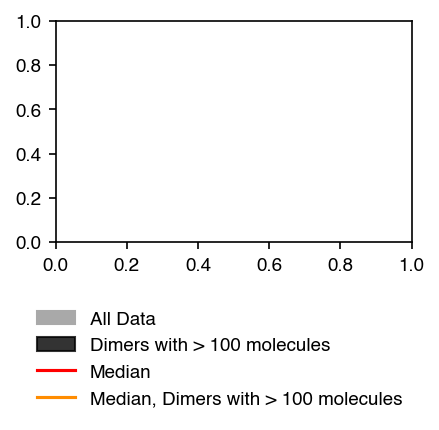

In [18]:
fig, ax = plt.subplots(figsize=(3,2))

# Make legend
patches={}
patches[f'light'] = mpatches.Patch(color='darkgray',edgecolor='none',label=f'All Data')
patches[f'dark'] = mpatches.Patch(color='k',edgecolor='none',alpha=0.8,label=f'Dimers with > 100 molecules')
patches['red'] = mlines.Line2D([], [], color='red',label='Median')
patches['darkorange'] = mlines.Line2D([], [], color='darkorange',label='Median, Dimers with > 100 molecules')

leg = fig.legend(bbox_to_anchor=(0.5, 0), loc='upper center',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    filename = f'FigS5Clegend'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Figure S5D

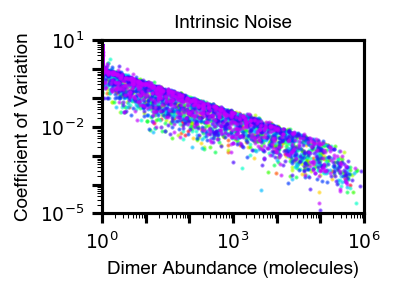

In [35]:
save = True 

fig, ax = plt.subplots(figsize=(2.25,1.5))
cmap = plt.get_cmap('gist_rainbow')

for m in m_list:
    m_i = m_list.index(m)
    S_all = S_all_by_m[m_i]
    S_all[np.where(S_all<1e-3)] = 1e-3
    for param_set_i in range(param_sets_per_m):
        _ = ax.plot(S_all[input_i_by_m_by_pset[m_i][param_set_i],:,param_set_i]/unitless_conc_per_molecule,\
                    coeff_noise_by_m_by_pset_by_species[m_i][param_set_i],marker='.',\
                    markersize=2,linestyle='',color=cmap(m_i/len(m_list)),alpha=0.5)

_ = ax.set_ylabel('Coefficient of Variation')
_ = ax.set_xlabel('Dimer Abundance\n(molecules/cell)')
_ = ax.set_title('Intrinsic Noise')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim([1e0,1e6])
ax.set_ylim([1e-5,1e1])

# Set ticks
set_simple_log_ticks(ax,which='x',log_lowerbound=0,log_upperbound=6,max_labels=4)
set_simple_log_ticks(ax,which='y',log_lowerbound=-5,log_upperbound=1,max_labels=4)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

# patches={}
# for m_i,m in enumerate(m_list):
#     patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

# leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
#     handles=list(patches.values()),\
#     edgecolor='white')

if save:
    filename = f'FigS5D_coeff_var_vs_abundance_by_network_size'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

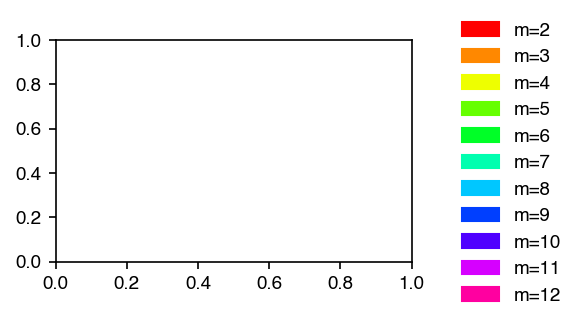

In [25]:
fig, ax = plt.subplots(figsize=(3,2))

# Make legend
patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

if save:
    filename = f'FigS5Dlegend'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Figure S5E: Robustness of Switch-off Function to Extrinsic Expression Noise

### Make Schematic (same as Figure 3B)

In [ ]:
m = 3
num_inputs = 1

In [ ]:
param_sets_versatile = {
    'stepdown': np.array([7.58874082e-01, 3.60550393e+03, 3.59318162e+01, 5.46408949e-03,
        8.70172144e+03, 1.05351010e+00, 1.00000000e-01, 1.34942191e+00]),
    'stepup': np.array([7.58874082e-01, 3.60550393e+03, 3.59318162e+01, 5.46408949e-03,
        8.70172144e+03, 1.05351010e+00, 2.62756786e+02, 2.61698411e+02]),
}

dimer_of_interest = make_nXn_species_names(m).index('D_3_3') - m # Index of dimer to use as output (D_1_1 = index 0)


In [ ]:
meta_name = 'stepup-stepdown-versatile'

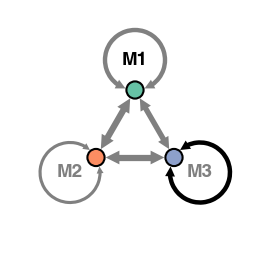

In [ ]:
save = True

name = 'stepdown'

K = param_sets_versatile[name][:-(m-num_inputs)]

fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=1, # Number of inputs
                                        param_sets=np.expand_dims(np.hstack((K,np.ones(m-num_inputs))),axis=0), # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest]]),
                                        input_node_values=np.array([0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = 0.3, # Radius of nodes around center
                                        r_loop = 0.2, # Radius of loops around nodes 
                                        node_scales = [-3,3,4,14.5], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,1,3], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set2', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        upscale_arrowhead=1.1,
                                        node_edge_width=1,
                                        )

fig.set_dpi(150)

if save:
    filename = f'FigS5F_{m}M_{meta_name}_{name}_schematic'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),pad_inches=0,bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,pad_inches=0,bbox_inches='tight')

### Plot the distribution used to perturb expression levels

In [8]:
# Gamma distribution parameters
independent_noise = 0.4

independent_shape = 1/(independent_noise**2)
independent_scale = independent_noise**2

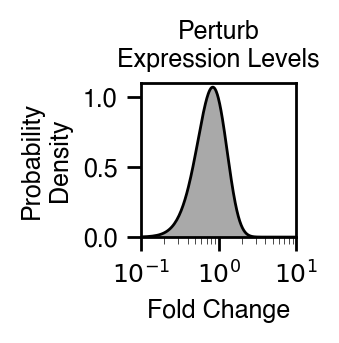

In [32]:
save = True

fig, ax = plt.subplots(figsize=(1,1))

x_points = np.linspace(0.1,10,1000)

PDF = scipy.stats.gamma.pdf(x_points,a=independent_shape,scale=independent_scale)

_ = ax.fill_between(x_points,PDF,0,color='darkgray',alpha=1,linewidth=0)
_ = ax.plot(x_points,PDF,color='k',linewidth=1,marker='',linestyle='-')

ax.set_xscale('log')
ax.set_ylim([0,1.1])
ax.set_xlim([0.1,10])

# Set ticks
set_simple_log_ticks(ax,which='x',log_lowerbound=-1,log_upperbound=1,max_labels=4)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

ax.set_ylabel('Probability\nDensity')
ax.set_xlabel('Fold Change')
ax.set_title('Perturb\nExpression Levels')

fig.set_dpi(200)

if save:
    filename = f'FigS5F_expression_distribution'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

### Plot Responses

In [ ]:
perturbed_responses_Fig3Bversatile = np.load(str(pathlib.Path(load_dir,'expression_noise_robustness','independent_perturbation',\
                            f'perturbed_responses_Fig3Bversatile.npy')), allow_pickle=True)

rmsds_Fig3Bversatile = np.load(str(pathlib.Path(load_dir,'expression_noise_robustness','independent_perturbation',\
                            f'rmsds_Fig3Bversatile.npy')), allow_pickle=True)

In [ ]:
median_rmsd = np.median(rmsds_Fig3Bversatile)

print('Median RMSD: {}'.format(round(median_rmsd,2)))

Median RMSD: 0.18


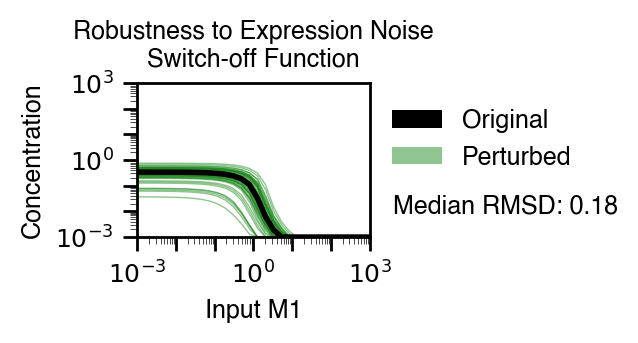

In [ ]:
save = True

fig, ax = plt.subplots(figsize=(1.5,1))

x_points = list(10**np.linspace(input_lb,input_ub,t,endpoint=True))

for param_set_i in range(1,num_A_sets):
    ax.plot(x_points,perturbed_responses_Fig3Bversatile[param_set_i],marker=None,linestyle='-',color='forestgreen',\
                        alpha=0.5,lw=0.5)
    
# Plot original
ax.plot(x_points,perturbed_responses_Fig3Bversatile[0],marker=None,linestyle='-',color='k',\
                        alpha=1,lw=2)


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([10**input_lb,10**input_ub])
ax.set_ylim([10**-3,10**3])

ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

# Set ticks
set_simple_log_ticks(ax,which='x',log_lowerbound=-3,log_upperbound=3,max_labels=4)
set_simple_log_ticks(ax,which='y',log_lowerbound=-3,log_upperbound=3,max_labels=4)

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

_ = ax.set_xlabel('Input M1')
_ = ax.set_ylabel('Concentration')
_ = ax.set_title('Robustness to Expression Noise\nSwitch-off Function')

patches={}
patches[f'original'] = mpatches.Patch(facecolor='k',linewidth=0,linestyle='',\
                                            alpha=1,label=f'Original',edgecolor=None)
patches[f'perturbed'] = mpatches.Patch(facecolor='forestgreen',linewidth=0,linestyle='',\
                                            alpha=0.5,label=f'Perturbed',edgecolor=None)

leg = fig.legend(bbox_to_anchor=(0.9, 0.6), loc='center left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

# Label RMSD
_ = ax.text(1.1, 0.2, f'Median RMSD: {round(median_rmsd,2)}', horizontalalignment='left', verticalalignment='center',\
            transform=ax.transAxes,fontsize=9)

fig.set_dpi(200)

if save:
    filename = f'FigS5F_{meta_name}_perturbed_responses'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Figure S5F: Robustness to Independent Monomer Expression Noise

In [ ]:
m_list = list(range(2,13))

num_A_sets = 50

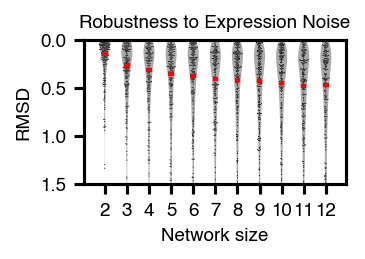

In [ ]:
save = True

fig, ax = plt.subplots(figsize=(2.25,1.25))

rng = np.random.default_rng()

dists_by_network_size = []

for m in m_list:
    euclidean_dists_by_function = np.load(str(pathlib.Path(load_dir,'expression_noise_robustness','independent_perturbation',\
                            f'{m}M',f'rmsds_by_function.npy')), allow_pickle=True)
    dists_by_network_size.append(list(itertools.chain.from_iterable(euclidean_dists_by_function)))

parts = ax.violinplot(positions = m_list,\
           dataset = dists_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('darkgray')
    face.set_alpha(1)

parts['cmedians'].set_color('r')
parts['cmedians'].set_linewidth(2)

subsample = 200
size = 0.5
for m,points in zip(m_list,dists_by_network_size):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

parts['cmedians'].set_zorder(10)

_ = ax.set_title('Robustness to Expression Noise')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'RMSD')
_ = ax.set_ylim([0, 1.5])

_ = ax.invert_yaxis()

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.5)   # Length and linewidth of minor ticks

if save:
    filename = f'FigS5E_independent_all_dists_by_network_size_rmsds'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

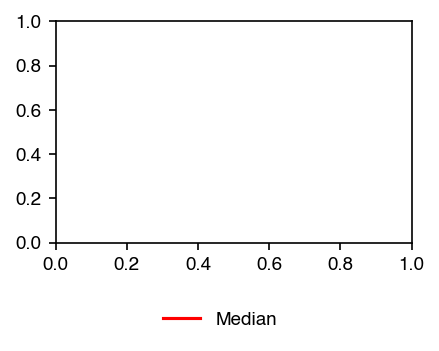

In [ ]:
fig, ax = plt.subplots(figsize=(3,2))

# Make legend
patches={}
patches['red'] = mlines.Line2D([], [], color='red',label='Median')

leg = fig.legend(bbox_to_anchor=(0.5, 0), loc='upper center',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')

if save:
    filename = f'FigS5Elegend'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished: Time to equilibration by Connectivity

In [19]:
m_list = list(range(2,13))

param_sets_per_m = 20

default_time = 10000 # s
max_time = 10000000 

vol_per_cell = 1e-12 # L
unitless_conc_per_molecule = 0.001

k_on = 5e5 # M-1 s-1
k_on_unitless = k_on/6.0221e23/vol_per_cell # molecule-1 s-1

rng = np.random.default_rng()

Load data:

In [20]:
input_i_at_eq = 29 # We simulated equilibration from input_i = 0 to input_i = 29

param_sets_by_m = []
S_all_by_m = []
num_edges_to_test_by_m = []
k_offs_by_m_by_pset_by_species = []
time_to_equilibrium_by_m_by_pset_by_species = [] 

for m in m_list:
    m_i = m_list.index(m)
    specific_out_dir = str(pathlib.Path(load_dir,'equilibration_time',f'{m}M'))
    param_sets_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'param_sets.npy')),allow_pickle=True))
    S_all_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'S_all.npy')),allow_pickle=True))
    num_edges_to_test_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'num_edges_to_test.npy')),allow_pickle=True))
    k_offs_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'k_offs_by_pset_by_species.npy')),allow_pickle=True))
    time_to_equilibrium_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'time_to_equilibrium_by_pset_by_species.npy')),allow_pickle=True))

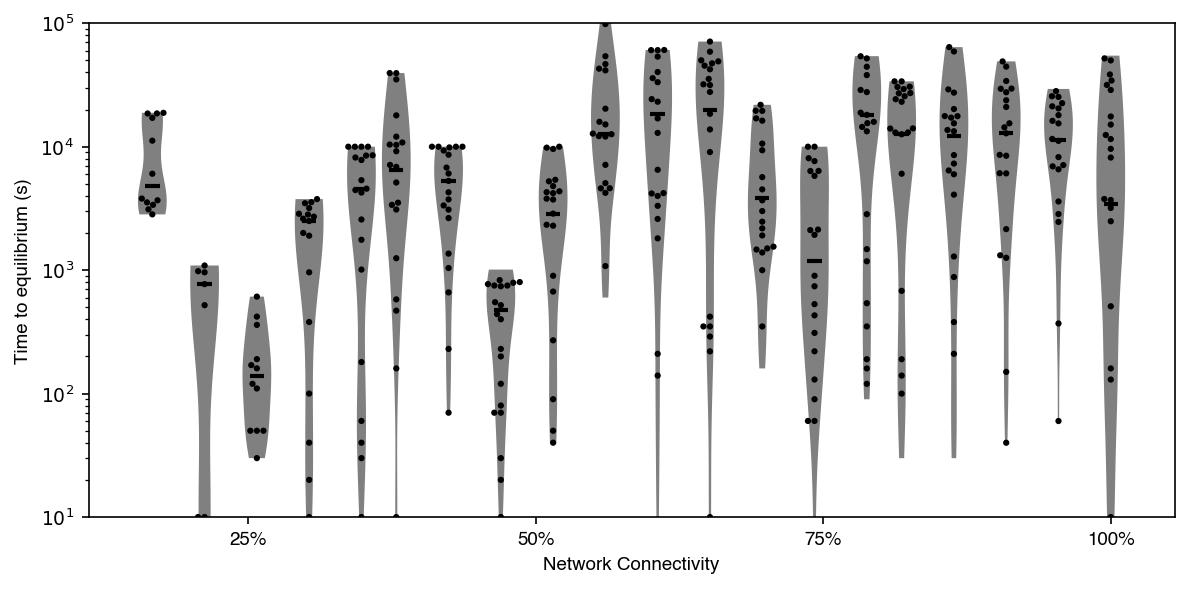

In [22]:
save = True

m = 12
m_i = m_list.index(m)

fig, ax = plt.subplots(figsize=(8,4))

time_to_equilibrium_by_num_edges = []
unique_num_edges = np.sort(np.unique(num_edges_to_test_by_m[m_i]))
connectivities = unique_num_edges/num_combos(m,2)
for num_edges_i,num_edges in enumerate(unique_num_edges):
    time_to_equilibrium = []
    for param_set_i in np.where(num_edges_to_test_by_m[m_i]==num_edges)[0]:
        time_to_equilibrium+=list(time_to_equilibrium_by_m_by_pset_by_species[m_i][param_set_i])
    time_to_equilibrium = np.array(time_to_equilibrium)
    time_to_equilibrium = time_to_equilibrium[np.where(time_to_equilibrium>0)]
    time_to_equilibrium_by_num_edges.append(np.log10(time_to_equilibrium))
    

parts = ax.violinplot(positions = connectivities,\
           dataset = time_to_equilibrium_by_num_edges,\
          #  labels = [str(m) for m in m_list],\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
            widths = 0.025,
)
for face in parts['bodies']:
    face.set_facecolor('darkgray')
    face.set_alpha(1)
parts['cmedians'].set_color('r')
parts['cmedians'].set_linewidth(2)

subsample = 20
size = 3
for connectivity,points in zip(connectivities,time_to_equilibrium_by_num_edges):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),connectivity),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

parts['cmedians'].set_zorder(10)

log_min_y = 1
log_max_y = 5
ax.set_ylim([log_min_y,log_max_y])
ax.set_yticks(range(log_min_y,log_max_y+1),labels=['$10^{{{}}}$'.format(x) for x in range(log_min_y,log_max_y+1)],minor=False)
ax.set_yticks(list(itertools.chain.from_iterable([[np.log10((10**x)*y) for y in np.arange(2,10)] \
            for x in range(log_min_y,log_max_y)])),minor=True)

_ = ax.set_xticks(np.linspace(0,1,5,endpoint=True))
_ = ax.set_xticklabels([f'{x:.0%}' for x in np.linspace(0,1,5,endpoint=True)])

_ = ax.set_ylabel('Time to equilibrium (s)')
_ = ax.set_xlabel('Network Connectivity')

if save:
    filename = f'{m}M_time_to_eq_by_network_connectivity'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished: Time to equilibration vs. Dimer Abundance

In [52]:
m_list = list(range(2,13))

param_sets_per_m = 20

default_time = 10000 # s
max_time = 10000000 

vol_per_cell = 1e-12 # L
unitless_conc_per_molecule = 0.001

k_on = 5e5 # M-1 s-1
k_on_unitless = k_on/6.0221e23/vol_per_cell # molecule-1 s-1

rng = np.random.default_rng()

In [23]:
def moving_average(x_vals, y_vals, window_size=None, num_windows=50):
    if window_size is None:
        x_range = np.max(x_vals) - np.min(x_vals)
        window_size = x_range/5
    x_window_centers = np.linspace(np.min(x_vals),np.max(x_vals),\
                                   num_windows,endpoint=True)
    x_window_means = [(x, np.mean(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])) \
                        if len(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])>0\
                        else (x, np.nan) \
                        for x, window in zip(x_window_centers,range(num_windows))]
    return np.array(x_window_means)

Load data:

In [54]:
input_i_at_eq = 29 # We simulated equilibration from input_i = 0 to input_i = 29

param_sets_by_m = []
S_all_by_m = []
num_edges_to_test_by_m = []
k_offs_by_m_by_pset_by_species = []
time_to_equilibrium_by_m_by_pset_by_species = [] 

for m in m_list:
    m_i = m_list.index(m)
    specific_out_dir = str(pathlib.Path(load_dir,'equilibration_time',f'{m}M'))
    param_sets_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'param_sets.npy')),allow_pickle=True))
    S_all_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'S_all.npy')),allow_pickle=True))
    num_edges_to_test_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'num_edges_to_test.npy')),allow_pickle=True))
    k_offs_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'k_offs_by_pset_by_species.npy')),allow_pickle=True))
    time_to_equilibrium_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'time_to_equilibrium_by_pset_by_species.npy')),allow_pickle=True))

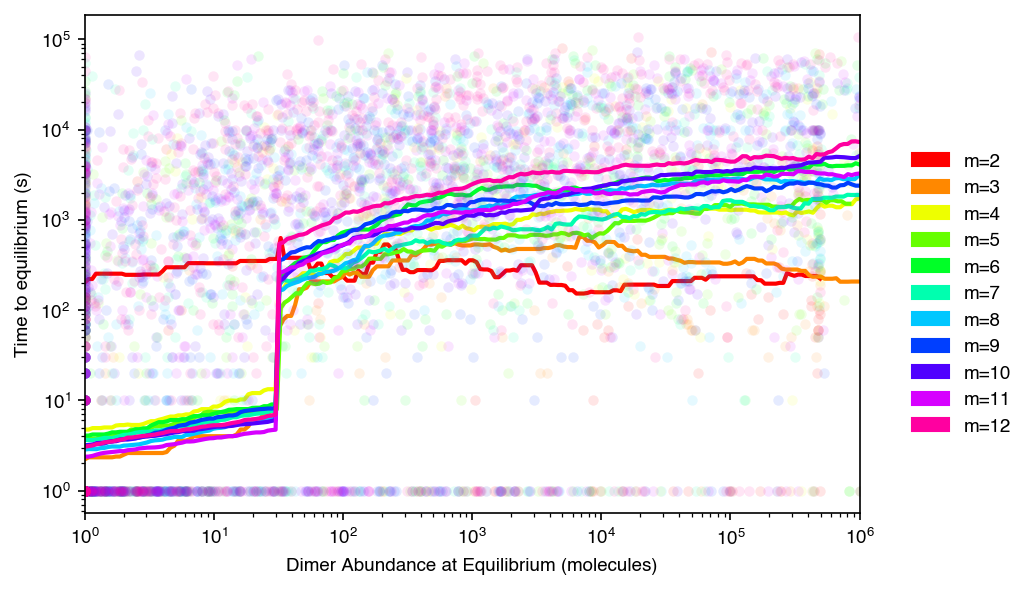

In [24]:
save = True

fig, ax = plt.subplots()
cmap = plt.get_cmap('gist_rainbow')

for m in m_list:
    m_i = m_list.index(m)
    S_all = S_all_by_m[m_i]
    S_all[np.where(S_all<1e-3)] = 1e-3
    all_x_data = []
    all_y_data = []
    for param_set_i in range(param_sets_per_m):
        time_to_equilibrium = np.array(time_to_equilibrium_by_m_by_pset_by_species[m_i][param_set_i])
        time_to_equilibrium[np.where(time_to_equilibrium==0)] = 1
        all_x_data += list(S_all[input_i_at_eq,:,param_set_i]/unitless_conc_per_molecule)
        all_y_data += list(time_to_equilibrium)
        _ = ax.plot(S_all[input_i_at_eq,:,param_set_i]/unitless_conc_per_molecule,time_to_equilibrium,marker='.',\
                    markersize=10,linestyle='',color=cmap(m_i/len(m_list)),alpha=0.1,markeredgewidth=0)
    x_window_means = moving_average(x_vals=np.log10(all_x_data), y_vals=np.log10(all_y_data), \
                                                      window_size=3, num_windows=200)
    _ = ax.plot(10**x_window_means[:,0],10**x_window_means[:,1],linestyle='-',marker='',color=cmap(m_i/len(m_list)),alpha=1,lw=2)

_ = ax.set_ylabel('Time to equilibrium (s)')
_ = ax.set_xlabel(r'Dimer Abundance at Equilibrium (molecules)')

# _ = ax.hlines(y=max_time,xmin=10**min_log_abundance,xmax=10**max_log_abundance,colors='k',linestyle='-')

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlim([10**0,10**6])

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

if save:
    filename = f'time_to_eq_vs_abdaunce_by_network_size_movingavg'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished: Time to equilibration vs. Dimer Affinity

In [58]:
m_list = list(range(2,13))

param_sets_per_m = 20

default_time = 10000 # s
max_time = 10000000 

vol_per_cell = 1e-12 # L
unitless_conc_per_molecule = 0.001

k_on = 5e5 # M-1 s-1
k_on_unitless = k_on/6.0221e23/vol_per_cell # molecule-1 s-1

rng = np.random.default_rng()

In [59]:
def moving_average(x_vals, y_vals, window_size=None, num_windows=50):
    if window_size is None:
        x_range = np.max(x_vals) - np.min(x_vals)
        window_size = x_range/5
    x_window_centers = np.linspace(np.min(x_vals),np.max(x_vals),\
                                   num_windows,endpoint=True)
    x_window_means = [(x, np.mean(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])) \
                        if len(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])>0\
                        else (x, np.nan) \
                        for x, window in zip(x_window_centers,range(num_windows))]
    return np.array(x_window_means)

Load data:

In [60]:
input_i_at_eq = 29 # We simulated equilibration from input_i = 0 to input_i = 29

param_sets_by_m = []
S_all_by_m = []
num_edges_to_test_by_m = []
k_offs_by_m_by_pset_by_species = []
time_to_equilibrium_by_m_by_pset_by_species = [] 

for m in m_list:
    m_i = m_list.index(m)
    specific_out_dir = str(pathlib.Path(load_dir,'equilibration_time',f'{m}M'))
    param_sets_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'param_sets.npy')),allow_pickle=True))
    S_all_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'S_all.npy')),allow_pickle=True))
    num_edges_to_test_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'num_edges_to_test.npy')),allow_pickle=True))
    k_offs_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'k_offs_by_pset_by_species.npy')),allow_pickle=True))
    time_to_equilibrium_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'time_to_equilibrium_by_pset_by_species.npy')),allow_pickle=True))

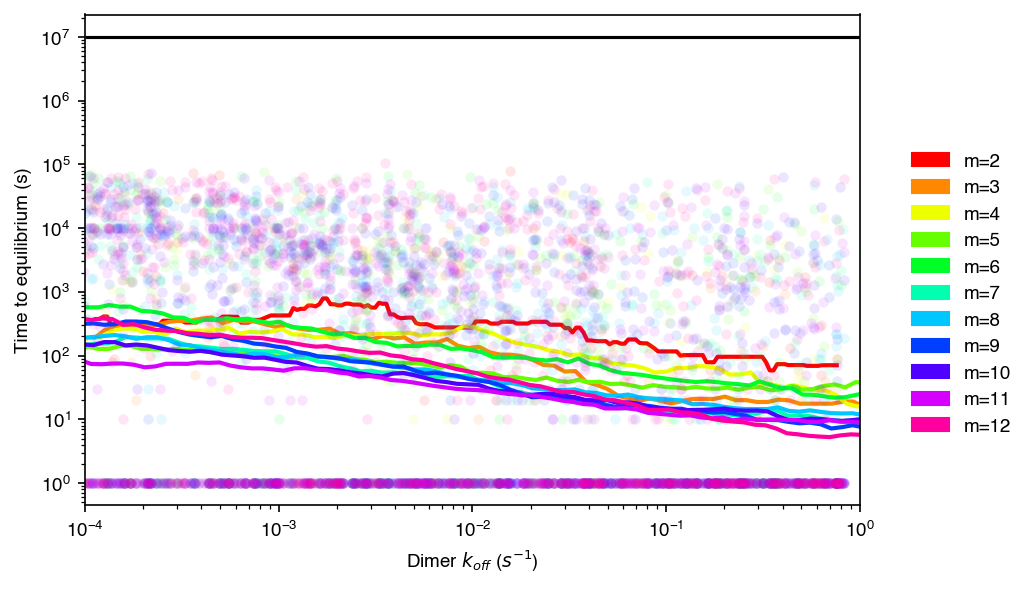

In [25]:
save = True

fig, ax = plt.subplots()
cmap = plt.get_cmap('gist_rainbow')

for m in m_list:
    m_i = m_list.index(m)
    all_x_data = []
    all_y_data = []
    for param_set_i in range(param_sets_per_m):
        k_offs = k_offs_by_m_by_pset_by_species[m_i][param_set_i]
        time_to_equilibrium = np.array(time_to_equilibrium_by_m_by_pset_by_species[m_i][param_set_i][m:])
        time_to_equilibrium[np.where(time_to_equilibrium==0)] = 1
        all_x_data += list(k_offs)
        all_y_data += list(time_to_equilibrium)
        _ = ax.plot(k_offs,time_to_equilibrium,marker='.',\
                    markersize=10,linestyle='',color=cmap(m_i/len(m_list)),alpha=0.1,markeredgewidth=0)
    x_window_means = moving_average(x_vals=np.log10(all_x_data), y_vals=np.log10(all_y_data), \
                                                      window_size=2, num_windows=200)
    _ = ax.plot(10**x_window_means[:,0],10**x_window_means[:,1],linestyle='-',marker='',color=cmap(m_i/len(m_list)),alpha=1,lw=2)

_ = ax.set_ylabel('Time to equilibrium (s)')
_ = ax.set_xlabel(r'Dimer $k_{off}$ ($s^{-1}$)')

min_koff = 1e-4
max_koff = 1e0

_ = ax.hlines(y=max_time,xmin=min_koff,xmax=max_koff,colors='k',linestyle='-')

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlim([min_koff,max_koff])

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

if save:
    filename = f'time_to_eq_vs_koff_by_network_size_movingavg'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished: Intrinsic Noise vs. Dimer Affinity

In [26]:
m_list = list(range(2,13))

param_sets_per_m = 20

default_time = 10000 # s
max_time = 10000000 

vol_per_cell = 1e-12 # L
unitless_conc_per_molecule = 0.001

k_on = 5e5 # M-1 s-1
k_on_unitless = k_on/6.0221e23/vol_per_cell # molecule-1 s-1

rng = np.random.default_rng()

Load data:

In [27]:
param_sets_by_m = []
S_all_by_m = []
num_edges_to_test_by_m = []
k_offs_by_m_by_pset_by_species = []
input_i_by_m_by_pset = []
coeff_noise_by_m_by_pset_by_species = []
stdev_noise_by_m_by_pset_by_species = []   

for m in m_list:
    m_i = m_list.index(m)
    specific_out_dir = str(pathlib.Path(load_dir,'intrinsic_noise',f'{m}M'))
    param_sets_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'param_sets.npy')),allow_pickle=True))
    S_all_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'S_all.npy')),allow_pickle=True))
    num_edges_to_test_by_m.append(np.load(str(pathlib.Path(specific_out_dir,f'num_edges_to_test.npy')),allow_pickle=True))
    k_offs_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'k_offs_by_pset_by_species.npy')),allow_pickle=True))
    input_i_by_m_by_pset.append(np.load(str(pathlib.Path(specific_out_dir,f'input_i_by_pset.npy')),allow_pickle=True))
    coeff_noise_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'coeff_noise_by_pset_by_species.npy')),allow_pickle=True))
    stdev_noise_by_m_by_pset_by_species.append(np.load(str(pathlib.Path(specific_out_dir,f'stdev_noise_by_pset_by_species.npy')),allow_pickle=True))

In [28]:
def moving_average(x_vals, y_vals, window_size=None, num_windows=50):
    if window_size is None:
        x_range = np.max(x_vals) - np.min(x_vals)
        window_size = x_range/5
    x_window_centers = np.linspace(np.min(x_vals),np.max(x_vals),\
                                   num_windows,endpoint=True)
    x_window_means = [(x, np.mean(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])) \
                        if len(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])>0\
                        else (x, np.nan) \
                        for x, window in zip(x_window_centers,range(num_windows))]
    return np.array(x_window_means)

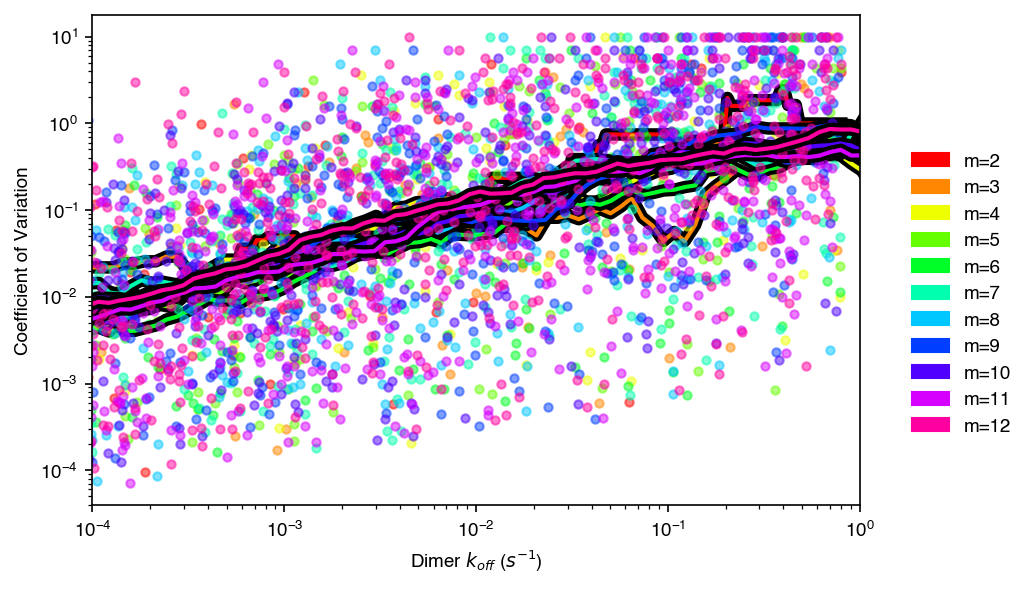

In [30]:
save = True

fig, ax = plt.subplots()
cmap = plt.get_cmap('gist_rainbow')

for m in m_list:
    m_i = m_list.index(m)
    all_x_data = []
    all_y_data = []
    for param_set_i in range(param_sets_per_m):
        k_offs = k_offs_by_m_by_pset_by_species[m_i][param_set_i]
        coeff_noise = np.array(coeff_noise_by_m_by_pset_by_species[m_i][param_set_i][m:])
        all_x_data+=list(k_offs)
        all_y_data+=list(coeff_noise)
        _ = ax.plot(k_offs,coeff_noise,marker='.',\
                    markersize=8,linestyle='',color=cmap(m_i/len(m_list)),alpha=0.5)
    all_x_data = np.array(all_x_data)
    all_y_data = np.array(all_y_data)
    all_x_data,all_y_data=  all_x_data[np.where((all_x_data>0)&(all_y_data>0))],all_y_data[np.where((all_x_data>0)&(all_y_data>0))]
    x_window_means = moving_average(x_vals=np.log10(all_x_data), y_vals=np.log10(all_y_data), \
                                                      window_size=1, num_windows=200)
    _ = ax.plot(10**x_window_means[:,0],10**x_window_means[:,1],linestyle='-',marker='',color='k',alpha=1,lw=6)
    _ = ax.plot(10**x_window_means[:,0],10**x_window_means[:,1],linestyle='-',marker='',color=cmap(m_i/len(m_list)),alpha=1,lw=2)
    

_ = ax.set_ylabel('Coefficient of Variation')
_ = ax.set_xlabel(r'Dimer $k_{off}$ ($s^{-1}$)')

min_koff = 1e-4
max_koff = 1e0

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlim([min_koff,max_koff])

patches={}
for m_i,m in enumerate(m_list):
    patches[f'm={m}'] = mpatches.Patch(color=cmap(m_i/(len(m_list))),label=f'm={m}')

leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
    handles=list(patches.values()),\
    edgecolor='white')

if save:
    filename = f'coeff_var_vs_koff_by_network_size'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished: Robustness to Independent Expression Noise, measured with other metrics

In [12]:
m_list = list(range(2,13))

num_A_sets = 50

In [15]:
metric = 'mean_abs_diff'

if metric=='chebyshev':
    filename = 'chebyshev_dists_by_function.npy'
    label = 'Chebyshev'
    yaxis = 'Chebyshev Distance'
    ymax = 3
elif metric=='mean_abs_diff':
    filename = 'mean_abs_diff_by_function.npy'
    label = 'Mean Difference'
    yaxis = 'Mean Difference'
    ymax = 1

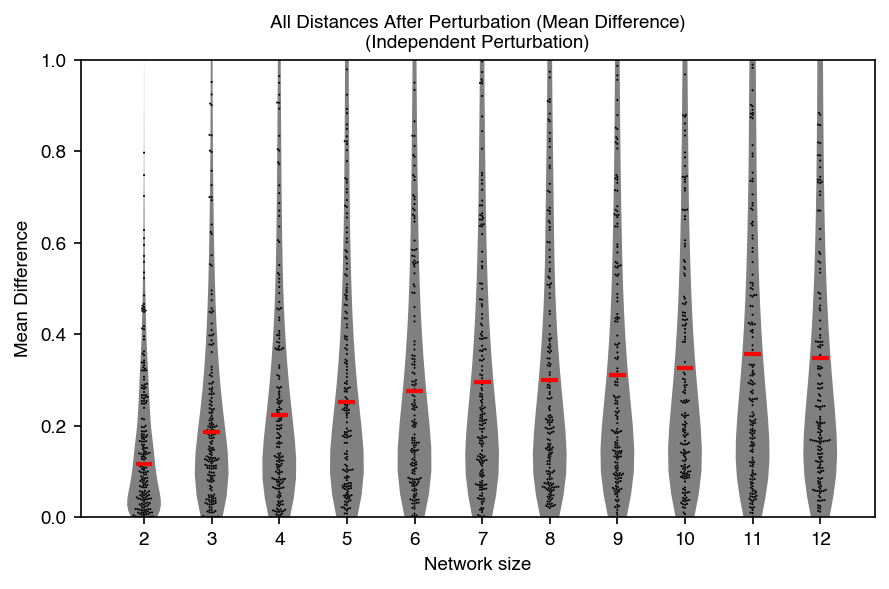

In [16]:
save = True

fig, ax = plt.subplots()
    
rng = np.random.default_rng()

dists_by_network_size = [list(itertools.chain.from_iterable(np.load(str(pathlib.Path(load_dir,'expression_noise_robustness','independent_perturbation',\
                            f'{m}M',filename)), allow_pickle=True)))\
                             for m in m_list]

parts = ax.violinplot(positions = m_list,\
           dataset = dists_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('darkgray')
    face.set_alpha(1)

parts['cmedians'].set_color('r')
parts['cmedians'].set_linewidth(2)

subsample = 200
size = 1
for m,points in zip(m_list,dists_by_network_size):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

parts['cmedians'].set_zorder(10)

_ = ax.set_title(f'All Distances After Perturbation ({label})\n(Independent Perturbation)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'{yaxis}')
_ = ax.set_ylim([0, ymax])

if save:
    filename = f'independent_all_dists_by_network_size_{metric}'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished: Robustness to Independent Expression Noise, measured as Number of Unique Functions

In [25]:
m_list = list(range(2,13))

num_A_sets = 50

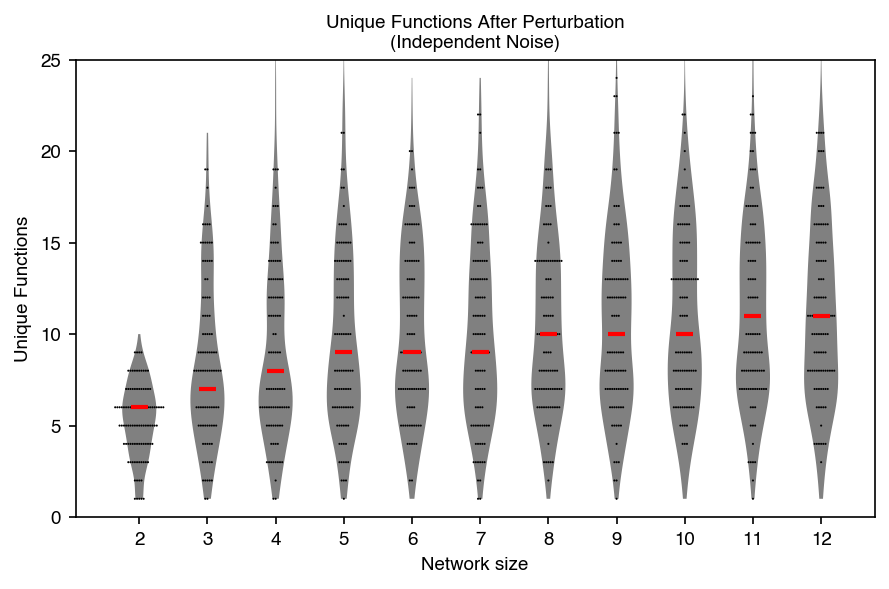

In [26]:
save = True

fig, ax = plt.subplots()

rng = np.random.default_rng()

unique_functions_by_network_size = []

for m in m_list:
    perturbed_voxels_by_original_voxel = np.load(str(pathlib.Path(load_dir,'expression_noise_robustness','independent_perturbation',\
                            f'{m}M',f'perturbed_voxels_by_original_voxel.npy')), allow_pickle=True)
    num_voxels_by_original_voxel = [x.shape[0] for x in perturbed_voxels_by_original_voxel]
    unique_functions_by_network_size.append(num_voxels_by_original_voxel)

parts = ax.violinplot(positions = m_list,\
           dataset = unique_functions_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('darkgray')
    face.set_alpha(1)

parts['cmedians'].set_color('r')
parts['cmedians'].set_linewidth(2)

subsample = 100
size = 1
for m,points in zip(m_list,unique_functions_by_network_size):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

parts['cmedians'].set_zorder(10)

_ = ax.set_title('Unique Functions After Perturbation\n(Independent Noise)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'Unique Functions')
_ = ax.set_ylim([0,25])

if save:
    filename = f'independent_voxels_by_network_size'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished: Robustness to Concerted (Extrinsic) Expression Noise

In [27]:
m_list = list(range(2,13))

num_A_sets = 50

In [36]:
metric = 'chebyshev'

if metric=='rmsd':
    filename = 'rmsds_by_function.npy'
    label = 'RMSD'
    yaxis = 'RMSD'
    ymax = 2
elif metric=='chebyshev':
    filename = 'chebyshev_dists_by_function.npy'
    label = 'Chebyshev'
    yaxis = 'Chebyshev Distance'
    ymax = 2
elif metric=='mean_abs_diff':
    filename = 'mean_abs_diff_by_function.npy'
    label = 'Mean Difference'
    yaxis = 'Mean Difference'
    ymax = 1

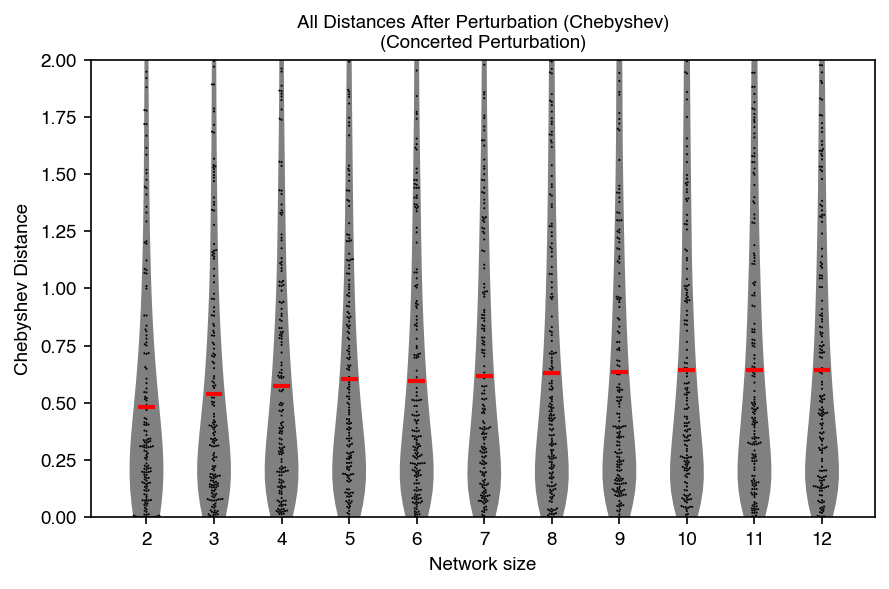

In [37]:
save = True

fig, ax = plt.subplots()

rng = np.random.default_rng()

dists_by_network_size = [list(itertools.chain.from_iterable(np.load(str(pathlib.Path(load_dir,'expression_noise_robustness','concerted_perturbation',\
                            f'{m}M',filename)), allow_pickle=True)))\
                             for m in m_list]

parts = ax.violinplot(positions = m_list,\
           dataset = dists_by_network_size,\
          showmedians=True,\
          showextrema=False,\
          showmeans=False,\
)
for face in parts['bodies']:
    face.set_facecolor('darkgray')
    face.set_alpha(1)

parts['cmedians'].set_color('r')
parts['cmedians'].set_linewidth(2)

subsample = 200
size = 1
for m,points in zip(m_list,dists_by_network_size):
    if len(points)>subsample:
        points = rng.choice(points,size=subsample,replace=False)
    subsample_df = pd.DataFrame({'m':np.full((len(points),),m),'y':points})
    sns.swarmplot(data=subsample_df,x='m',y='y',orient='v', native_scale=True,\
        color='k',size=size,alpha=1,edgecolor='none',ax=ax)

parts['cmedians'].set_zorder(10)

_ = ax.set_title(f'All Distances After Perturbation ({label})\n(Concerted Perturbation)')
_ = ax.set_xlabel('Network size')
_ = ax.set_xticks(m_list)
_ = ax.set_ylabel(f'{yaxis}')
_ = ax.set_ylim([0, ymax])

if save:
    filename = f'concerted_all_dists_by_network_size_{metric}'
    plt.tight_layout()
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Unpublished: What do gene expression Gamma distributions look like?

In [63]:
def moving_average(x_vals, y_vals, window_size=None, num_windows=50):
    if window_size is None:
        x_range = np.max(x_vals) - np.min(x_vals)
        window_size = x_range/5
    x_window_centers = np.linspace(np.min(x_vals),np.max(x_vals),\
                                   num_windows,endpoint=True)
    x_window_means = [(x, np.mean(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])) \
                        if len(y_vals[np.where((x_vals>=x_window_centers[window]-(window_size/2))&\
                                                (x_vals<=x_window_centers[window]+(window_size/2)))[0]])>0\
                        else (x, np.nan) \
                        for x, window in zip(x_window_centers,range(num_windows))]
    return np.array(x_window_means)

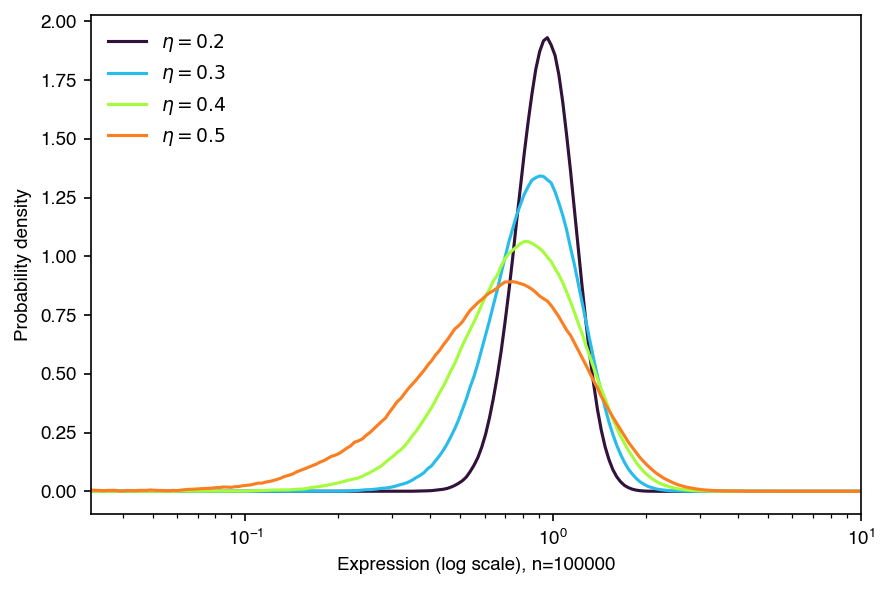

In [36]:
save = True

rng = np.random.default_rng()

fig, ax = plt.subplots(figsize=(6,4))

# noise = 0.5

n_samples = 100000

xmin, xmax = 10**-1.5,1e1
ax.set_xlim([xmin,xmax])

noise_levels = [0.2,0.3,0.4,0.5]

normalize = False

cmap = plt.get_cmap('turbo')

for i,noise in enumerate(noise_levels):

    shape = 1/(noise**2)
    scale = noise**2

    samples = rng.gamma(shape=shape,scale=scale,size=(n_samples,))

    # log_samples = np.log10(samples)

    # histogram = plt.hist(log_samples,bins=100,density=True)

    num_bins = 400
    # bins = np.linspace(xmin,xmax,num_bins,endpoint=True)
    bins = np.logspace(np.log10(xmin),np.log10(xmax),num_bins,endpoint=True)

    hist,_ = np.histogram(samples,bins =  bins,density=True) 
    if normalize:
        hist = hist / np.sum(hist)

    # ax.stairs(hist,bins,color=cmap(i/len(noise_levels)),linewidth=1,alpha=1)

    log_bin_centers = (np.log10(bins[1:]) + np.log10(bins[:-1]))/2
    x_window_means = moving_average(x_vals=log_bin_centers,y_vals=hist, window_size=0.1, num_windows=200)

    ax.plot(10**x_window_means[:,0],x_window_means[:,1],linestyle='-',marker='',color=cmap(i/len(noise_levels)),alpha=1,lw=1.5)

    ax.set_xscale('log')

_ = ax.set_xlabel(f'Expression (log scale), n={n_samples}')
_ = ax.set_ylabel('Probability density')

patches={}
for i,noise in enumerate(noise_levels):
    patches[f'{i}'] = mlines.Line2D([], [], color=cmap(i/len(noise_levels)), marker='', linestyle='-',label='$\eta={}$'.format(noise))

leg = ax.legend(loc='upper left',facecolor='none',\
    handles=list(patches.values()),\
    edgecolor='none')


fig.set_dpi(150)


if save:
    plt.tight_layout()
    filename = f'gamma_distributions'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')
